## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 多通道 高低頻項分解 的模型訓練成果 ###



### 導入模型設定與套件 ###

In [239]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

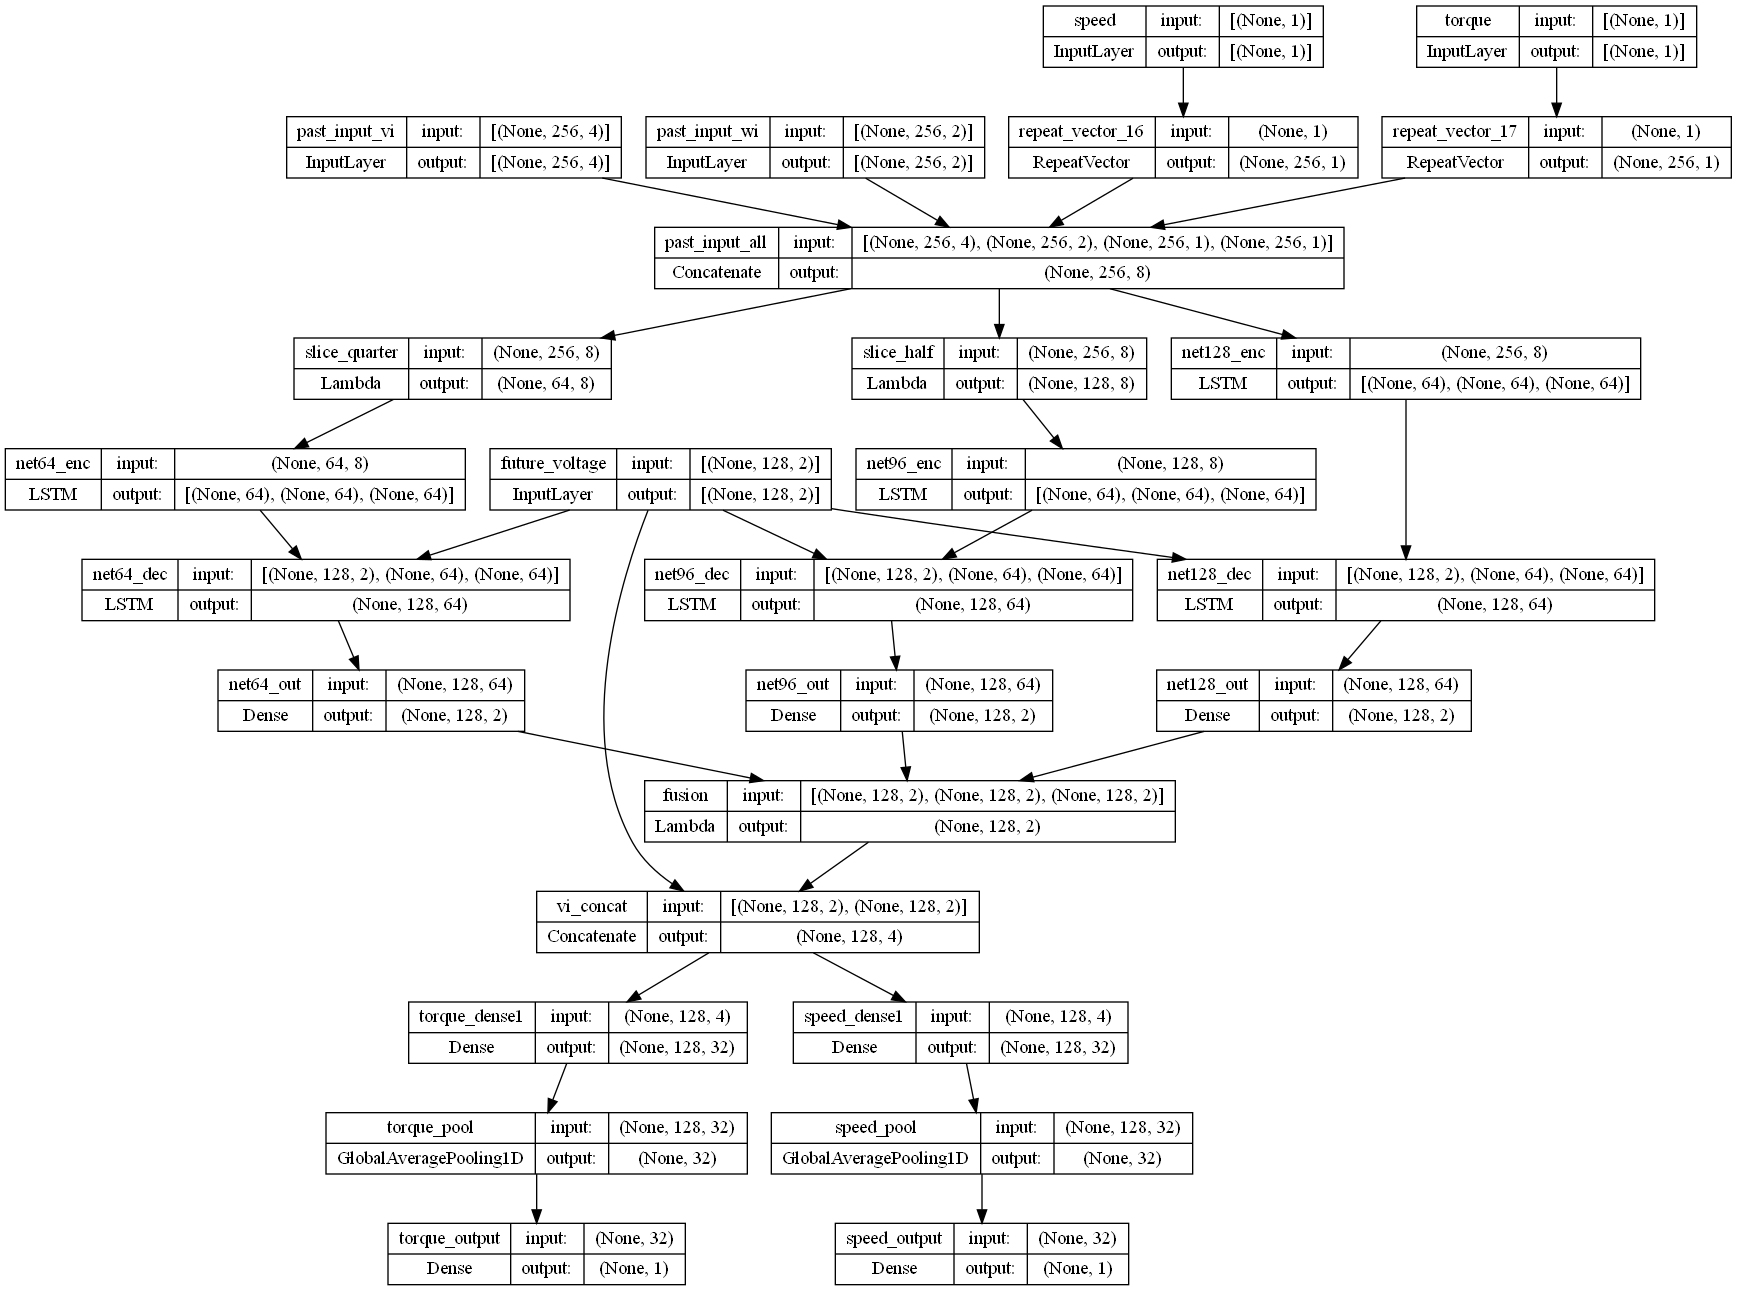

In [240]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K

# Initial model parameters
sequence_length=256
layer_number=1
future_length=128

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_direct_lstm_multiscale_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_multiscale_lstm_fusion_model(past_length=128, future_length=128, latent_dim=64):
    
    # 單一輸入：過去最多128步的 V+I（共4維）
    past_input_all = Input(shape=(past_length, 4), name='past_vi_all')
    future_voltage = Input(shape=(future_length, 2), name='future_voltage')

    # 定義分割視窗（Lambda）
    def slice_past(x, start_idx):
        return x[:, start_idx:, :]

    x_quater = Lambda(lambda x: slice_past(x, past_length-past_length//4), name="slice64")(past_input_all)
    x_half = Lambda(lambda x: slice_past(x, past_length-past_length//2), name="slice96")(past_input_all)
    x_all = past_input_all

    # 定義共用子網路函式
    def decoder_branch(x_in, name):
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_voltage, initial_state=[h, c])
        return Dense(2, name=f"{name}_out")(x)

    # 各分支子網路
    out_64 = decoder_branch(x_quater, "net64")
    out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    # 加權平均（此處簡化為平均）
    output_current = Lambda(lambda x: (x[0]+x[1]+x[2])/3.0, name="fusion")([out_64, out_96, out_128])
    output_torque = Dense(1, name="torquel_output")(output_current)

    model = Model(inputs=[past_input_all, future_voltage], outputs=[output_current, output_torque], name="MSSW_LSTM_AutoSplit")
   
    
    return model

def build_multiscale_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=64):
    
    # === 輸入 ===
    past_input_vi = Input(shape=(past_length, 4), name='past_input_vi')       # V + I (共4維)
    past_input_wi = Input(shape=(past_length, 2), name='past_input_wi')       # 電流*速度(共4維)
    speed = Input(shape=(1,), name='speed')                                   # 速度（1維）
    torque = Input(shape=(1,), name='torque')                                 # 扭矩（1維）
    future_voltage = Input(shape=(future_length, 2), name='future_voltage')   # 未來電壓（2維）

    # === speed, torque 展開為序列 ===
    speed_repeat = RepeatVector(past_length)(speed)       # shape: (batch_size, past_length, 1)
    torque_repeat = RepeatVector(past_length)(torque)     # shape: (batch_size, past_length, 1)

    # === 合併成完整輸入 ===
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_vi, past_input_wi,  speed_repeat, torque_repeat])

    # === 多尺度切片（1/4、1/2、全部）===
    def slice_past(x, start_idx):
        return x[:, start_idx:, :]

    x_quarter = Lambda(lambda x: slice_past(x, past_length - past_length // 4), name="slice_quarter")(past_input_all)
    x_half    = Lambda(lambda x: slice_past(x, past_length - past_length // 2), name="slice_half")(past_input_all)
    x_all     = past_input_all

    # === 解碼分支 ===
    def decoder_branch(x_in, name):
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_voltage, initial_state=[h, c])
        return Dense(2, name=f"{name}_out")(x)  # 預測未來電流

    out_64 = decoder_branch(x_quarter, "net64")
    out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    # === 三尺度融合 ===
    output_current = Lambda(lambda x: (x[0] + x[1] + x[2]) / 3.0, name="fusion")([out_64, out_96, out_128])

    # === VI 組合（用於 torque、speed 預測） ===
    merged_features = Concatenate(name="vi_concat", axis=-1)([output_current, future_voltage])  # shape: (batch, future_length, 4)

    # === Torque 分支 ===
    torque_features = Dense(32, activation='relu', name="torque_dense1")(merged_features)
    pooled_torque = GlobalAveragePooling1D(name="torque_pool")(torque_features)
    output_torque = Dense(1, name="torque_output")(pooled_torque)

    # === Speed 分支 ===
    speed_features = Dense(32, activation='relu', name="speed_dense1")(merged_features)
    pooled_speed = GlobalAveragePooling1D(name="speed_pool")(speed_features)
    output_speed = Dense(1, name="speed_output")(pooled_speed)

    # === 建立模型 ===
    model = Model(
        inputs=[past_input_vi, past_input_wi, speed, torque, future_voltage],
        outputs=[output_current, output_torque, output_speed],
        name="MSSW_LSTM_MultiTask3"
    )

    return model

# build model 
my_model = build_multiscale_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
my_model.compile(
    optimizer='adam',
    loss={
        'fusion': 'mse',
        'torque_output': 'mse',
        'speed_output': 'mse',
    },
    loss_weights={
        'fusion': 1.0,        # 主任務：電流
        'torque_output': 0.5,
        'speed_output': 0.5,
    },
    metrics={
        'fusion': 'mae',
        'torque_output': 'mae',
        'speed_output': 'mae',
    }
)

# my_model.compile(optimizer='adam', loss='mse')

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


In [241]:

my_model.save(os.path.join(model_path, model_name + '.keras'))
        

### 資料前處理 ###

In [242]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data


# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_1_0V", "1800_2_0V", "1200_1_0V"]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)

train_signals=[]
torque_array=[]
speed_array=[]

for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path)
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  np.array(df["Current alpha downsample"]),
                                  np.array(df["Current beta downsample"])] 
                                  
        
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        augmen_sample_number=1000  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array = np.concatenate(speed_array, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]


torque_array=torque_array[indices]
speed_array=speed_array[indices]
# 將 torque_array 轉為 n, 1 batch 輸入
torque_array = torque_array.reshape(-1, 1)
speed_array = speed_array.reshape(-1, 1)
speed_current = train_input_signals[:,:,2:4] * speed_array[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")




train_input_signals shape: (60000, 256, 4)
train_fit_signals shape: (60000, 128, 4)
torque_array shape: (60000, 1)
speed_current shape: (60000, 256, 2)


### 模型訓練 ###

In [243]:

history = my_model.fit(
    x=[train_input_signals, speed_current, speed_array, torque_array, future_voltages], 
    y={
        'fusion': future_currents,
        'torque_output': torque_array,
        'speed_output': speed_array,
    },
    batch_size=64,
    epochs=10,
    validation_split=0.1
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/10
185/844 [=====>........................] - ETA: 26s - loss: 4.1370 - fusion_loss: 0.1808 - torque_output_loss: 1.8983 - speed_output_loss: 6.0141 - fusion_mae: 0.2844 - torque_output_mae: 0.8349 - speed_output_mae: 1.1724

KeyboardInterrupt: 

In [ ]:
print(f"Train input signals shape: {train_input_signals.shape}")
# print(x_128.shape)
# === 載入測試資料 ===

testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1200_2_0V\RUL_Data_3_2.parquet"
test_data = read_rul_data(testfile)
start_idx=112

# test_data = read_rul_data(val_files[0])  # 使用第一個驗證檔案進行測試


Train input signals shape: (60000, 256, 4)


### 驗證結果 ###

past_vi shape: (1, 256, 4)
speed_current_past shape: (1, 256, 2)
x_future shape: (1, 128, 2)
speed shape: ()
torque shape: ()
past_current shape: (256, 2)
1/1 [==============================] - 0s 59ms/step


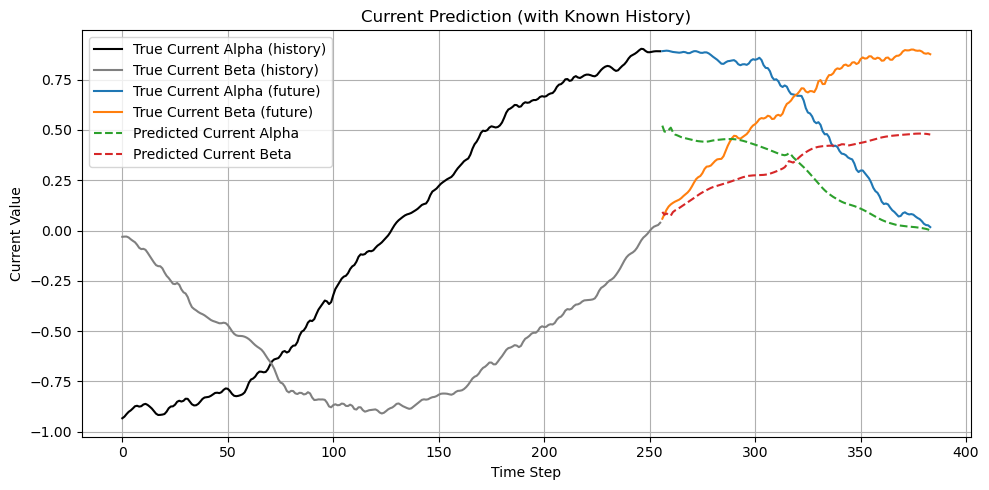

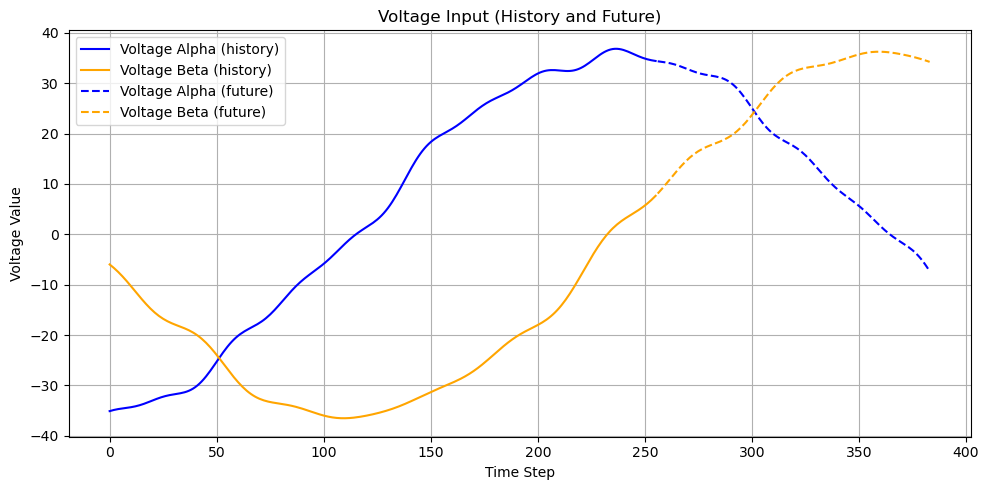

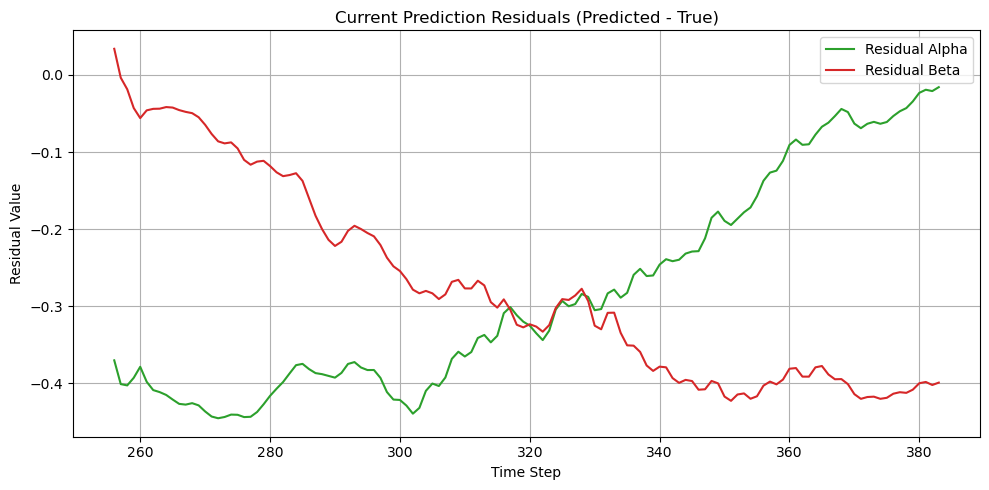

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def direct_forecast(model, past_voltage, past_current, future_voltage):
    """
    For MSSW_LSTM_AutoSplit version (accepts [past_vi_all, future_voltage])
    """
    past_vi_all = np.concatenate([past_voltage, past_current], axis=1)  # shape: (128, 4)
    past_vi_all = np.expand_dims(past_vi_all, axis=0).astype(np.float32)  # (1, 128, 4)
    future_voltage = np.expand_dims(future_voltage, axis=0).astype(np.float32)  # (1, 128, 2)

    pred_current, pred_torque, pred_speed = model.predict([past_vi_all, future_voltage], verbose=0)
    return pred_current, pred_torque, pred_speed  # 去掉 batch 維度

# V/I歷史輸入與未來電壓
past_vi = np.stack([
    test_data["Voltage alpha downsample"][:sequence_length],
    test_data["Voltage beta downsample"][:sequence_length],
    test_data["Current alpha downsample"][:sequence_length],
    test_data["Current beta downsample"][:sequence_length]
], axis=1)  # shape (128, 4)
past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


speed_current_past = np.stack([
    test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
    test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
], axis=1)  # shape (128, 2)
speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)

x_future = np.stack([
    test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)
x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

true_future_current = np.stack([
    test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
    test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
], axis=1)

speed= (test_data["Speed"][0]/3000).astype(np.float32)
torque= (test_data["Torque avg"]).astype(np.float32)

past_voltage = past_vi[0, :, 0:2]
past_current = past_vi[0, :, 2:4]


# 確認資料形狀
# 印出輸入變數名稱與形狀
print(f"past_vi shape: {past_vi.shape}")
print(f"speed_current_past shape: {speed_current_past.shape}")
print(f"x_future shape: {x_future.shape}")
print(f"speed shape: {speed.shape}")
print(f"torque shape: {torque.shape}")
print(f"past_current shape: {past_current.shape}")



# === 預測 ===
y_future_pred, pred_torque, pred_speed = my_model.predict([
    past_vi, 
    speed_current_past, 
    np.array([[speed]]), 
    np.array([[torque]]), 
    x_future
])
y_future_pred=y_future_pred[0]  # 去掉 batch 維度




# === 繪圖：歷史 + 未來預測 ===
plt.figure(figsize=(10, 5))
plt.plot(range(sequence_length), past_current[:, 0], color='black', label='True Current Alpha (history)')
plt.plot(range(sequence_length), past_current[:, 1], color='gray', label='True Current Beta (history)')
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 0], color='tab:blue', label='True Current Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[:, 1], color='tab:orange', label='True Current Beta (future)')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted Current Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted Current Beta')
plt.title('Current Prediction (with Known History)')
plt.xlabel('Time Step')
plt.ylabel('Current Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 繪圖：電壓輸入 ===
plt.figure(figsize=(10, 5))
plt.plot(range(sequence_length), past_voltage[:, 0], color='blue', label='Voltage Alpha (history)')
plt.plot(range(sequence_length), past_voltage[:, 1], color='orange', label='Voltage Beta (history)')
plt.plot(range(sequence_length, sequence_length+future_length), x_future[0][:, 0], color='blue', linestyle='--', label='Voltage Alpha (future)')
plt.plot(range(sequence_length, sequence_length+future_length), x_future[0][:, 1], color='orange', linestyle='--', label='Voltage Beta (future)')
plt.title('Voltage Input (History and Future)')
plt.xlabel('Time Step')
plt.ylabel('Voltage Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === 繪圖：預測誤差 ===

plt.figure(figsize=(10, 5))
residuals = y_future_pred - true_future_current
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label='Residual Alpha')
plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label='Residual Beta')
plt.title('Current Prediction Residuals (Predicted - True)')
plt.xlabel('Time Step')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 建立中間層輸出模型
intermediate_model = Model(
    inputs=my_model.inputs,
    outputs=[
        my_model.get_layer("net64_out").output,   # 1/4 長度
        my_model.get_layer("net96_out").output,   # 1/2 長度
        my_model.get_layer("net128_out").output,  # 全部長度
        my_model.get_layer("fusion").output       # 融合輸出
    ]
)

# 預測並取得中間結果
out_64_pred, out_96_pred, out_128_pred, fused_output = intermediate_model.predict(
    [x_128, speed, torque, x_future]
)

# 假設 true_future_current 是 shape (future_length, 2)
# 每個 out_* 的 shape 應為 (1, future_length, 2) — 取第0個batch，alpha是 [:, 0]
true_alpha = true_future_current[:, 0]
pred_64 = out_64_pred[0, :, 0]
pred_96 = out_96_pred[0, :, 0]
pred_128 = out_128_pred[0, :, 0]
pred_fused = fused_output[0, :, 0]

plt.figure(figsize=(12, 6))
plt.plot(true_alpha, label='True Current Alpha', linewidth=2)
plt.plot(pred_64, label='Predicted Alpha - net64 (1/4)', linestyle='--')
plt.plot(pred_96, label='Predicted Alpha - net96 (1/2)', linestyle='--')
plt.plot(pred_128, label='Predicted Alpha - net128 (Full)', linestyle='--')
plt.plot(pred_fused, label='Fused Prediction', linestyle='-.')

plt.title('Current Alpha Prediction Comparison')
plt.xlabel('Future Time Step')
plt.ylabel('Current Alpha (A)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.float32'>", "<class 'numpy.ndarray'>"}), <class 'NoneType'>